In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 14.7 MB/s 


In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as T
from collections import defaultdict, deque
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import ast
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import cv2
import os,sys,matplotlib,re
from PIL import Image
from skimage import exposure
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.image as immg

import warnings
warnings.filterwarnings("ignore")
import matplotlib

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
# path = '../input/gwd-512-image-resized/'
train_df = pd.read_csv('/content/drive/MyDrive/pred_prof/data/train.csv')

train_dataframe = pd.DataFrame()
row_data = []
cnt = 0
for index, row in train_df.iterrows():
    # print(row['image_name'], row['BoxesString'].split(";"))
    boxes = row['BoxesString'].split(";")
    for box in boxes:
        if box!='no_box':
            b = list(map(int,box.split(" ")))
            for index, value in enumerate(b):
                if value >= 1024:
                    b[index] = 1023
        if 1023 in b:            
            print("Skip row", row['image_name'])
            cnt += 1
        else:
            row_data.append([row['image_name'], 1024, 1024, b])
print(cnt)    
train_dataframe = pd.DataFrame(row_data, columns=['image_id','width','height','bbox'])
train_dataframe

Выходные данные были обрезаны до нескольких последних строк (5000).
Skip row da8b16a78b8be0692051984d3dc9ee9e7b0eccadfde4775889d528ff8d74e07a.png
Skip row da8b16a78b8be0692051984d3dc9ee9e7b0eccadfde4775889d528ff8d74e07a.png
Skip row da8b16a78b8be0692051984d3dc9ee9e7b0eccadfde4775889d528ff8d74e07a.png
Skip row 5c21f2ab81c6102585f36196fd47ceafe3e464c29a049edc591025d793451520.png
Skip row 5c21f2ab81c6102585f36196fd47ceafe3e464c29a049edc591025d793451520.png
Skip row 5c21f2ab81c6102585f36196fd47ceafe3e464c29a049edc591025d793451520.png
Skip row 5c21f2ab81c6102585f36196fd47ceafe3e464c29a049edc591025d793451520.png
Skip row 0a512c8bc9a4c5c71065357f50a3fc18ad31170132d03ff4409d5fcf8fb1f829.png
Skip row 0a512c8bc9a4c5c71065357f50a3fc18ad31170132d03ff4409d5fcf8fb1f829.png
Skip row 0a512c8bc9a4c5c71065357f50a3fc18ad31170132d03ff4409d5fcf8fb1f829.png
Skip row 0a512c8bc9a4c5c71065357f50a3fc18ad31170132d03ff4409d5fcf8fb1f829.png
Skip row 0a512c8bc9a4c5c71065357f50a3fc18ad31170132d03ff4409d5fcf8fb1f829.

,image_id,width,height,bbox
0,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[460, 411, 517, 444]"
1,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[911, 43, 981, 86]"
2,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[214, 951, 295, 1015]"
3,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[247, 778, 298, 817]"
4,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[553, 368, 591, 406]"
...,...,...,...,...
181462,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[0, 543, 86, 644]"
181463,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[374, 343, 453, 433]"
181464,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[187, 984, 270, 1022]"
181465,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[251, 263, 346, 350]"


In [ ]:
if b=='no_box':
    train_dataframe.drop(labels=['image_id','width','width','bbox'],axis=1,inplace=True)

train_dataframe

,image_id,width,height,bbox
0,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[460, 411, 517, 444]"
1,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[911, 43, 981, 86]"
2,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[214, 951, 295, 1015]"
3,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[247, 778, 298, 817]"
4,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[553, 368, 591, 406]"
...,...,...,...,...
181462,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[0, 543, 86, 644]"
181463,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[374, 343, 453, 433]"
181464,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[187, 984, 270, 1022]"
181465,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[251, 263, 346, 350]"


In [ ]:
train_df=train_dataframe.copy()

In [ ]:
train_df

,image_id,width,height,bbox
0,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[460, 411, 517, 444]"
1,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[911, 43, 981, 86]"
2,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[214, 951, 295, 1015]"
3,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[247, 778, 298, 817]"
4,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,"[553, 368, 591, 406]"
...,...,...,...,...
181462,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[0, 543, 86, 644]"
181463,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[374, 343, 453, 433]"
181464,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[187, 984, 270, 1022]"
181465,cd1c4510d1eca1e8a0c6b7e96d2f4410f13f452be2ee71...,1024,1024,"[251, 263, 346, 350]"


In [ ]:
train_df[['x_min','y_min','x_max','y_max']] = pd.DataFrame(train_df.bbox.tolist(), index= train_df.index)
train_df['w']=train_df['x_max']-train_df['x_min']
train_df['h']=train_df['y_max']-train_df['y_min']
train_df.drop('bbox', axis=1, inplace=True)
train_df.describe()

,width,height,x_min,y_min,x_max,y_max,w,h
count,181467.0,181467.0,181467.000000,181467.000000,181467.000000,181467.000000,181467.000000,181467.000000
mean,1024.0,1024.0,455.032998,458.797324,531.788926,531.147680,76.755928,72.350356
std,0.0,0.0,289.126100,287.991352,288.437526,287.365766,38.584560,37.777034
min,1024.0,1024.0,0.000000,0.000000,1.000000,4.000000,1.000000,2.000000
25%,1024.0,1024.0,200.000000,209.000000,281.000000,284.000000,50.000000,47.000000
50%,1024.0,1024.0,457.000000,458.000000,534.000000,532.000000,70.000000,65.000000
75%,1024.0,1024.0,705.000000,709.000000,783.000000,780.000000,94.000000,89.000000
max,1024.0,1024.0,1015.000000,1013.000000,1022.000000,1022.000000,705.000000,516.000000


In [ ]:
df = train_df.copy()

In [ ]:
df.head()

,image_id,width,height,x_min,y_min,x_max,y_max,w,h
0,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,460,411,517,444,57,33
1,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,911,43,981,86,70,43
2,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,214,951,295,1015,81,64
3,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,247,778,298,817,51,39
4,dcdc5b40ba4901a52a03f6fcc0d7f882678534b696b677...,1024,1024,553,368,591,406,38,38


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df_grp = df.groupby(['image_id'])
b_fea = ['x_min', 'y_min', 'x_max', 'y_max']

In [ ]:
path='/content/drive/MyDrive/pred_prof/data/images/'

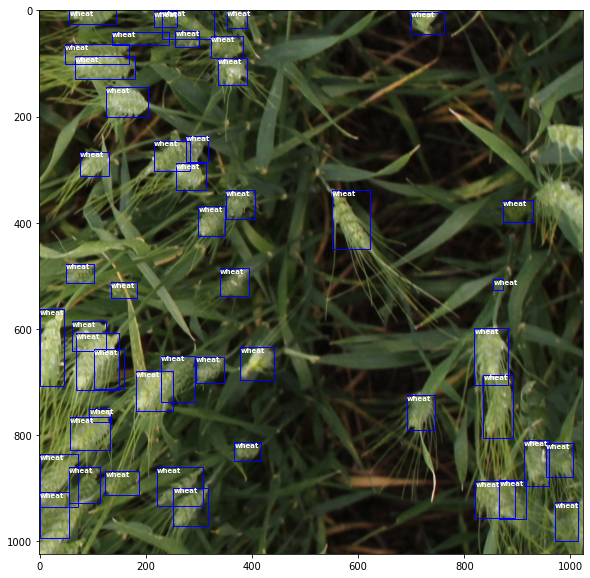

,x_min,y_min,x_max,y_max
1209,56,0,143,26
1210,136,40,244,65
1211,353,0,390,33
1212,231,0,329,54
1213,256,38,301,69
1214,322,48,384,89
1215,336,90,390,141
1216,48,63,168,100
1217,66,86,179,130
1218,125,144,205,200


In [ ]:
name = df.image_id.unique()[34]
loc = path+name
aaa = df_grp.get_group(name)
bbx = aaa.loc[:,b_fea]
img = immg.imread(loc)
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img,cmap='binary')
for i in range(len(bbx)):
    box = bbx.iloc[i].values
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='white', fontsize=7, weight='bold')
    ax.add_patch(rect)
plt.show()
bbx

In [ ]:
class WheatDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        self.a = 0
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['image_id'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(self.img_dir+image_id,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros((records.shape[0],), dtype=torch.int64)
    
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        # print(torch.tensor(image), target, image_id)
        return torch.tensor(image), target, image_id

In [ ]:
IMG_SIZE = (1024,1024)

In [ ]:
! pip install albumentations

     |████████████████████████████████| 631 kB 13.9 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=7e41cea940af098b4064f63b22bbc31e044de46753ba6b69154be95c521a3069
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
img_dir = "/content/drive/MyDrive/pred_prof/data/images/"

In [ ]:
WDS = WheatDataset(df, img_dir, get_train_transform())

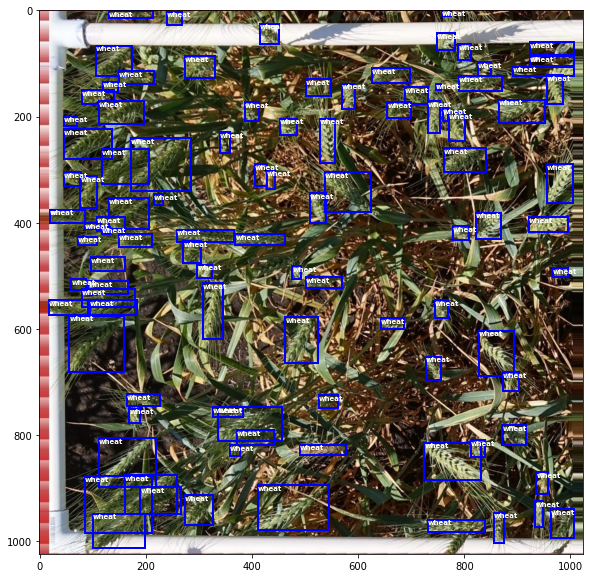

In [ ]:
import random
img, tar, _ = WDS[random.randint(0,1000)]
bbox = tar['boxes'].numpy()
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for i in range(len(bbox)):
    box = bbox[i]
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='b',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='white', fontsize=7, weight='bold')
    ax.add_patch(rect)
plt.show()

In [ ]:
image_ids = df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]
train_df.shape,valid_df.shape

((156310, 9), (25157, 9))

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, img_dir, get_train_transform())
valid_dataset = WheatDataset(valid_df, img_dir, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
num_classes = 2  # 1 class (wheat) + background
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.2):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [ ]:
num_epochs = 70

In [ ]:
loss_hist = Averager()
best_epoch = 0
min_loss = sys.maxsize
for epoch in range(num_epochs):
    loss_hist.reset()
    tk = tqdm(train_data_loader)
    print(tk)
    model.train();
    for images, targets, image_ids in tk:
        # print(image_ids)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 
    
    if loss_hist.value<min_loss:
        print("Better model found at epoch {0} with {1:0.5f} loss value".format(epoch,loss_hist.value))
        torch.save(model.state_dict(), f"/content/drive/MyDrive/pred_prof/data/epoch3/model_state_epoch_{epoch}.pth")
        min_loss = loss_hist.value
        best_epoch = epoch
    #validation 
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
        
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to('cuda') for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                val_out = apply_nms(val_output[j])
                a,b = val_out['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()
        
model.load_state_dict(torch.load(f"/content/drive/MyDrive/pred_prof/data/epoch3/model_state_epoch_{best_epoch}.pth"));

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #0 loss: 1.0019119023325134
Better model found at epoch 0 with 1.00191 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #1 loss: 0.8483343789679727
Better model found at epoch 1 with 0.84833 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #2 loss: 0.8153678562755164
Better model found at epoch 2 with 0.81537 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #3 loss: 0.7840955002094236
Better model found at epoch 3 with 0.78410 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #4 loss: 0.7790634519220581
Better model found at epoch 4 with 0.77906 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #5 loss: 0.7759488467550384
Better model found at epoch 5 with 0.77595 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #6 loss: 0.7721946599294095
Better model found at epoch 6 with 0.77219 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #7 loss: 0.7737280058949173


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #8 loss: 0.773152300609608


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #9 loss: 0.7739238921021608


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #10 loss: 0.7734562770618872


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #11 loss: 0.7728299280476458


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #12 loss: 0.7730699048700688


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #13 loss: 0.7713313699509609
Better model found at epoch 13 with 0.77133 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #14 loss: 0.7722714496207441


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #15 loss: 0.7727979213601964


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #16 loss: 0.772527081692386


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #17 loss: 0.7720516561137966


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #18 loss: 0.7730147945037104


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #19 loss: 0.7732721572444916


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #20 loss: 0.77232357164324


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #21 loss: 0.7736907375954262


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #22 loss: 0.7727534567014775


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #23 loss: 0.7726033967483679


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #24 loss: 0.7726916013791683


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #25 loss: 0.7728180780625017


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #26 loss: 0.773704065323633


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #27 loss: 0.7728628857236308


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #28 loss: 0.7729684610751371


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #29 loss: 0.7724226035808105


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #30 loss: 0.7731439741156642


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #31 loss: 0.7720956531734142


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #32 loss: 0.7722137094383521


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #33 loss: 0.7728384170467709


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #34 loss: 0.7725503260774298


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #35 loss: 0.7726723504113078


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #36 loss: 0.7722729426263987


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #37 loss: 0.7729466011231421


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #38 loss: 0.7731093660012377


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #39 loss: 0.7730512415945479


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #40 loss: 0.7720589648415829


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #41 loss: 0.7725957332318154


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #42 loss: 0.773011649926663


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #43 loss: 0.7721530206574748


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #44 loss: 0.7714230221386371


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #45 loss: 0.773024135510222


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #46 loss: 0.7715170632025525


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #47 loss: 0.7729221466323891


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #48 loss: 0.7726469795287756


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #49 loss: 0.7728933013056047


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #50 loss: 0.7727827491785337


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #51 loss: 0.7727500585438494


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #52 loss: 0.7724675291803198


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #53 loss: 0.7745958739614512


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #54 loss: 0.7729073743236425


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #55 loss: 0.7727552944323407


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #56 loss: 0.7717335382680158


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #57 loss: 0.7737577018921147


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #58 loss: 0.7717332620782793


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #59 loss: 0.7727648294735876


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #60 loss: 0.7710723758896835
Better model found at epoch 60 with 0.77107 loss value


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #61 loss: 0.7725109714834629


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #62 loss: 0.7725600044839093


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #63 loss: 0.7727974776575413


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #64 loss: 0.7719545160440132


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #65 loss: 0.7717321982619965


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #66 loss: 0.7715566338636649


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #67 loss: 0.7720562569385815


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #68 loss: 0.7729449051095695


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]
Epoch #69 loss: 0.7723224009664345


  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
best_epoch=60

In [ ]:
pip install onnx

In [ ]:
pip install onnx-tf  

In [ ]:
import onnx
from onnx_tf.backend import prepare
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
dummy_input = Variable(torch.randn(1, 3, 256, 256))


# device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state_dict = torch.load("/content/drive/MyDrive/pred_prof/data/epoch3/model_state_epoch_60.pth")
# model = Net()
# model.cuda()
model.load_state_dict(state_dict, strict=True)
# dummy_input = torch.from_numpy(x_test[0].reshape(1, -1)).float().to(device)
dummy_output = model(dummy_input)
# model.cuda()
model = model.to(device)
model.eval()
# print(model)
torch.onnx.export(model, dummy_input, "vitstr.onnx")
# torch.onnx.export(model, dummy_input, "/content/drive/MyDrive/pred_prof/model_state_epoch_60.onnx")

RuntimeError: ignored

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# if torch.cuda.is_available():
#     model.cuda()
model.load_state_dict(torch.load(f"/content/drive/MyDrive/pred_prof/data/epoch3/model_state_epoch_{best_epoch}.pth"), strict=False);

RuntimeError: ignored

In [ ]:
dummy_input = Variable(torch.randn(1, 1, 28, 28))

In [ ]:
torch.onnx.export(model, dummy_input, "/content/drive/MyDrive/pred_prof/model_state_epoch_60_3.onnx",opset_version=11)

RuntimeError: ignored

In [ ]:
model_onnx = onnx.load('/content/drive/MyDrive/pred_prof/model_state_epoch_60.onnx')
try:
    onnx.checker.check_model(model_onnx)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

The model is valid!


In [ ]:
tf_rep = prepare(model_onnx, logging_level='DEBUG')

2022-02-16 19:52:50,799 - onnx-tf - DEBUG - Fail to get since_version of Celu in domain `` with max_inclusive_version=11. Set to 1.
2022-02-16 19:52:50,801 - onnx-tf - DEBUG - Unknown op ConstantFill in domain `ai.onnx`.
2022-02-16 19:52:50,803 - onnx-tf - DEBUG - Fail to get since_version of Einsum in domain `` with max_inclusive_version=11. Set to 1.
2022-02-16 19:52:50,805 - onnx-tf - DEBUG - Fail to get since_version of GreaterOrEqual in domain `` with max_inclusive_version=11. Set to 1.
2022-02-16 19:52:50,806 - onnx-tf - DEBUG - Fail to get since_version of HardSwish in domain `` with max_inclusive_version=11. Set to 1.
2022-02-16 19:52:50,807 - onnx-tf - DEBUG - Unknown op ImageScaler in domain `ai.onnx`.
2022-02-16 19:52:50,808 - onnx-tf - DEBUG - Fail to get since_version of LessOrEqual in domain `` with max_inclusive_version=11. Set to 1.
2022-02-16 19:52:50,811 - onnx-tf - DEBUG - Fail to get since_version of Trilu in domain `` with max_inclusive_version=11. Set to 1.


In [ ]:
print(tf_rep.inputs) # Input nodes to the model
print('-----')
print(tf_rep.outputs) # Output nodes from the model
print('-----')
print(tf_rep.tensor_dict) # All nodes in the model

['images']
-----
['3214', '3191', '3190']
-----
{}


In [ ]:
tf_rep.export_graph('/content/drive/MyDrive/pred_prof/model_state_epoch_60_tf.pb')
tf_rep.saved_model.save(net, "saved_model")

RuntimeError: ignored

In [ ]:
model.load_state_dict(torch.load(f"/content/drive/MyDrive/pred_prof/data/epoch3/model_state_epoch_{best_epoch}.pth"));

In [ ]:
model.predict(valid_dataset[1])

AttributeError: ignored

In [ ]:
valid_dataset[1]

(tensor([[[0.0980, 0.1059, 0.1176,  ..., 0.3804, 0.3608, 0.3373],
          [0.1059, 0.1098, 0.1137,  ..., 0.4235, 0.3961, 0.3725],
          [0.1137, 0.1098, 0.1059,  ..., 0.4667, 0.4275, 0.4118],
          ...,
          [0.1804, 0.1765, 0.1725,  ..., 0.4118, 0.4078, 0.4157],
          [0.1765, 0.1765, 0.1765,  ..., 0.4157, 0.4039, 0.4157],
          [0.1725, 0.1686, 0.1686,  ..., 0.4118, 0.4039, 0.4118]],
 
         [[0.1216, 0.1294, 0.1216,  ..., 0.2745, 0.2510, 0.2314],
          [0.1255, 0.1294, 0.1216,  ..., 0.3137, 0.2941, 0.2784],
          [0.1255, 0.1294, 0.1255,  ..., 0.3765, 0.3529, 0.3333],
          ...,
          [0.1725, 0.1686, 0.1647,  ..., 0.4039, 0.4039, 0.4078],
          [0.1647, 0.1647, 0.1647,  ..., 0.4196, 0.4078, 0.4471],
          [0.1608, 0.1608, 0.1608,  ..., 0.4118, 0.4157, 0.4196]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.2196, 0.2000, 0.1804],
          [0.0902, 0.0902, 0.0902,  ..., 0.2431, 0.2275, 0.2078],
          [0.0902, 0.0980, 0.0980,  ...,

In [ ]:
img,target,_ = valid_dataset[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to('cuda')])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  34
real #boxes:  16


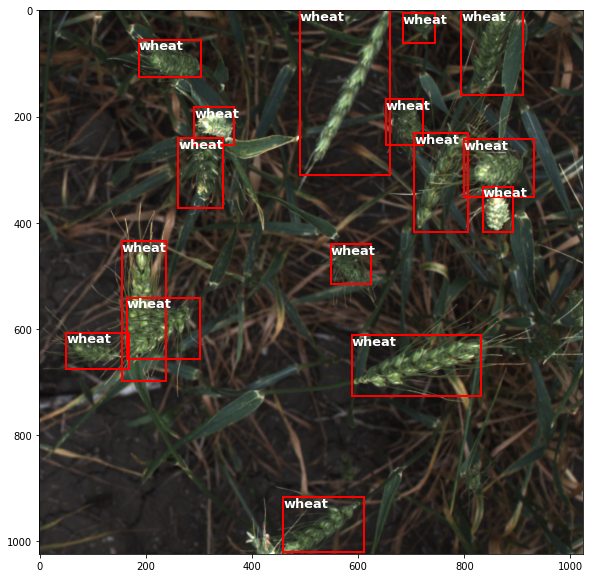

In [ ]:
bbox = target['boxes'].numpy()
fig,ax = plt.subplots(1,figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for i in range(len(bbox)):
    box = bbox[i]
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='white', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()

In [ ]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = img.permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    nms_prediction = apply_nms(prediction, iou_thresh=0.2) if nms else prediction
    val_scores = nms_prediction['scores'].cpu().detach().numpy()
    bbox = nms_prediction['boxes'].cpu().detach().numpy()
    cnt = 0
    for i in range(len(bbox)):
        if val_scores[i]>=detect_thresh:
            box = bbox[i]
            x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
            # ax.text(*box[:2], "wheat {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
            ax.text(*box[:2], "wheat {0:.3f}".format(i), verticalalignment='top', color='white', fontsize=12, weight='bold')
            cnt += 1
            ax.add_patch(rect)
    print(cnt)
    plt.show()

17


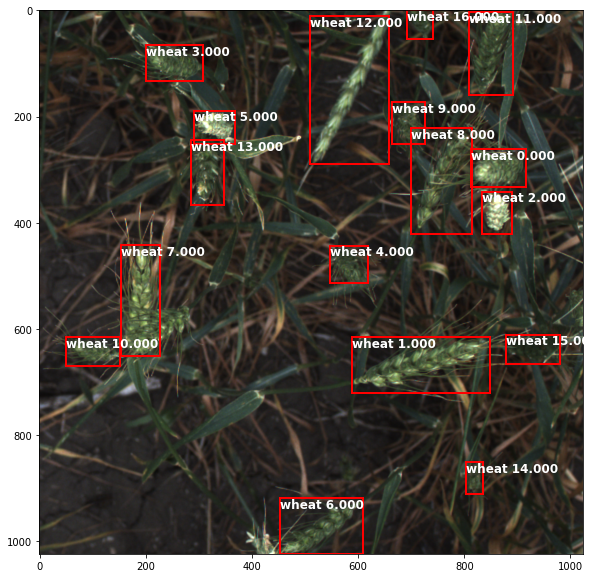

In [ ]:
plot_valid(img,prediction)